# アルゴリズムの発見の流れ
- ①特徴的な変数の考察
- ②特徴量を考える。
- ③アルゴリズムの実装
- 用意されたデータは既にtrainとtestに分かれており、アルゴリズムからtrainデータの予測ができるアルゴリズムをまずは完成させたい。
- まずは過学習を無視して、近づけるカギを見つけたい（クロスバリデーションを無視）

In [1]:
#データの読み込み
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF
import seaborn as sns

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")

train.index = pd.to_datetime(train["datetime"])

train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [2]:
train.describe()

,y,soldout,kcal,payday,temperature
count,207.000000,207.000000,166.000000,10.0,207.000000
mean,86.623188,0.449275,404.409639,1.0,19.252174
std,32.882448,0.498626,29.884641,0.0,8.611365
min,29.000000,0.000000,315.000000,1.0,1.200000
25%,57.000000,0.000000,386.000000,1.0,11.550000
50%,78.000000,0.000000,408.500000,1.0,19.800000
75%,113.000000,1.000000,426.000000,1.0,26.100000
max,171.000000,1.000000,462.000000,1.0,34.600000


In [3]:
train["remarks"] = train["remarks"].fillna("なし")
train["event"] = train["event"].fillna("なし")
train["payday"] = train["payday"].fillna(0)
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x) )
train["month"] = train["datetime"].apply(lambda x :int(x.split("-")[1]))

In [4]:
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month
datetime,,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,なし,なし,0.0,快晴,-1.0,19.8,11
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,なし,なし,0.0,快晴,-1.0,17.0,11
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,なし,なし,0.0,快晴,-1.0,15.5,11
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,なし,なし,0.0,快晴,-1.0,15.2,11
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,なし,なし,0.0,快晴,-1.0,16.1,11


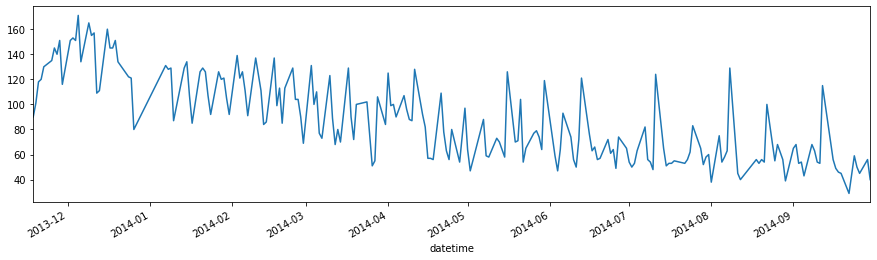

In [5]:
train["y"].plot(figsize=(15,4))

In [6]:
train[train["month"]==1].sort_values(by="y")

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month
datetime,,,,,,,,,,,,,
2014-01-17,2014-1-17,85,金,1,回鍋肉,430.0,なし,ママの会,0.0,快晴,-1.0,7.8,1
2014-01-10,2014-1-10,87,金,0,手作りロースカツ,440.0,なし,なし,1.0,快晴,-1.0,5.1,1
2014-01-31,2014-1-31,92,金,1,メダイ照り焼,460.0,なし,なし,0.0,快晴,-1.0,14.1,1
2014-01-24,2014-1-24,92,金,1,鶏のレモンペッパー焼orカレー,418.0,鶏のレモンペッパー焼（50食）、カレー（42食）,なし,0.0,快晴,-1.0,10.1,1
2014-01-30,2014-1-30,105,木,1,鶏の唐揚げ,448.0,なし,なし,0.0,曇,-1.0,15.3,1
2014-01-16,2014-1-16,107,木,0,カレイ唐揚げ野菜あんかけ,415.0,なし,なし,0.0,快晴,-1.0,7.0,1
2014-01-23,2014-1-23,107,木,0,酢豚,400.0,なし,なし,0.0,快晴,-1.0,8.5,1
2014-01-28,2014-1-28,120,火,0,海老フライタルタル,445.0,なし,なし,0.0,快晴,-1.0,12.6,1
2014-01-29,2014-1-29,121,水,1,チーズ入りメンチカツ,450.0,なし,なし,0.0,快晴,-1.0,10.3,1


- 年月が経つにつれて平均的に下がっている印象（⇒線形モデルに応用できそう）

### 相関関係の確認
- それぞれの変数と売り上げの相関関係の確認。
- 今回は、変数が数値のものは散布図、ステータスのものは箱ひげ図で表す。

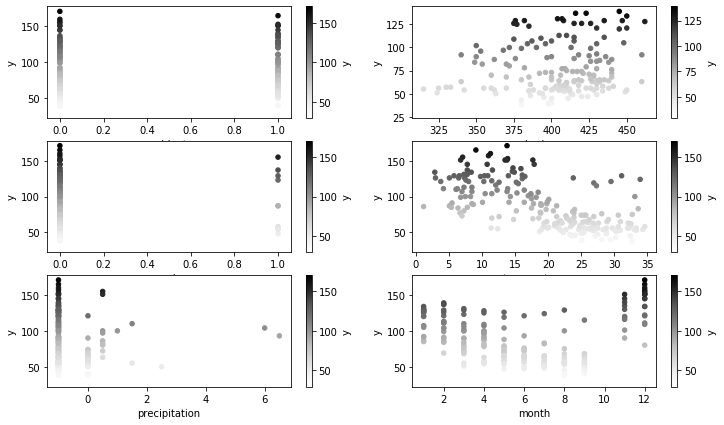

In [7]:
fig,ax = plt.subplots(3,2,figsize=(12,7))

train.plot.scatter(x="soldout",y="y",ax=ax[0][0],c=1)
train.plot.scatter(x="kcal",y="y",ax=ax[0][1],c=1)
train.plot.scatter(x="payday",y="y",ax=ax[1][0],c=1)
train.plot.scatter(x="temperature",y="y",ax=ax[1][1],c=1)
train.plot.scatter(x="precipitation",y="y",ax=ax[2][0],c=1)
train.plot.scatter(x="month",y="y",ax=ax[2][1],c=1)

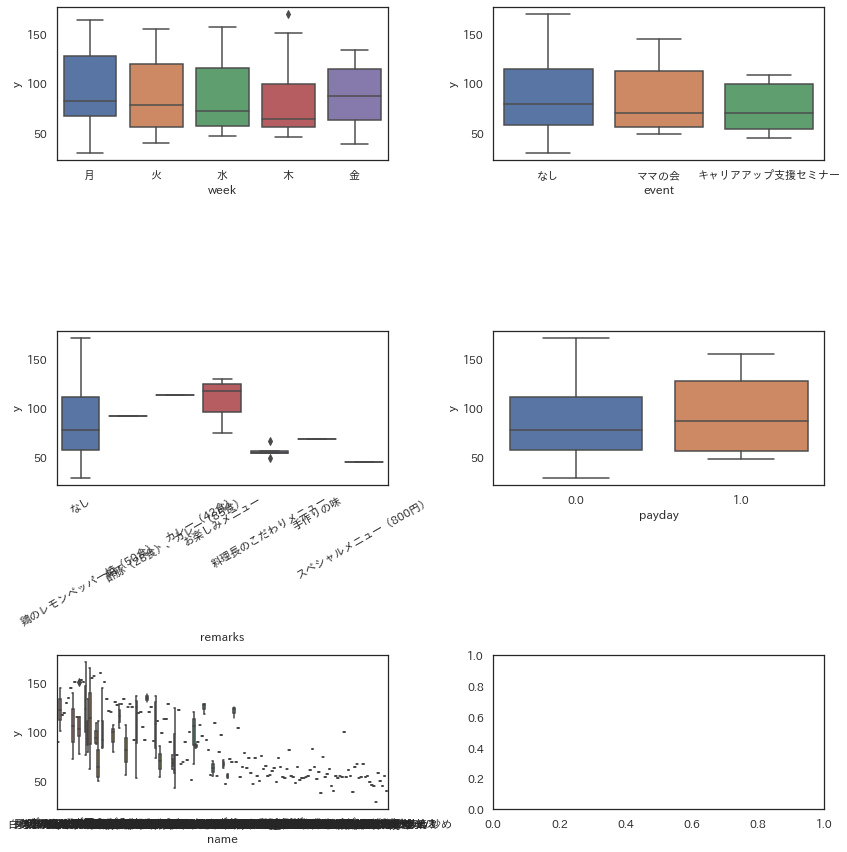

In [8]:
sns.set(font="IPAexGothic",style="white")#日本語の指定
fig, ax = plt.subplots(3,2,figsize=(12,12))

sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="event",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=30)
sns.boxplot(x="payday",y="y",data=train,ax=ax[1][1])
sns.boxplot(x="name",y="y",data=train,ax=ax[2][0])
plt.tight_layout()

In [9]:
train["remarks"].value_counts()

なし                          186
お楽しみメニュー                     12
料理長のこだわりメニュー                  5
鶏のレモンペッパー焼（50食）、カレー（42食）      1
酢豚（28食）、カレー（85食）              1
手作りの味                         1
スペシャルメニュー（800円）               1
Name: remarks, dtype: int64

In [10]:
train.sort_values(by="y")

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month
datetime,,,,,,,,,,,,,
2014-09-22,2014-9-22,29,月,0,筑前煮,395.0,なし,なし,0.0,晴れ,-1.0,25.2,9
2014-08-01,2014-8-1,38,金,0,豚肉の生姜焼き,380.0,なし,なし,0.0,薄曇,-1.0,32.7,8
2014-08-29,2014-8-29,39,金,0,チキンの辛味噌焼き,398.0,なし,なし,0.0,曇,0.0,25.1,8
2014-09-30,2014-9-30,40,火,0,鶏肉とカシューナッツ炒め,398.0,なし,なし,0.0,快晴,-1.0,28.1,9
2014-08-12,2014-8-12,40,火,1,厚切ハムカツ,400.0,なし,なし,0.0,雨,0.0,29.4,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-10,2013-12-10,155,火,0,やわらかロースのサムジョン,NaN,なし,なし,1.0,曇,0.5,7.1,12
2013-12-11,2013-12-11,157,水,0,五目御飯,NaN,なし,なし,0.0,曇,-1.0,11.0,12
2013-12-16,2013-12-16,160,月,0,カキフライタルタル,NaN,なし,なし,0.0,快晴,-1.0,11.3,12


In [11]:
train[train["y"] < 57]["name"].value_counts()

タンドリーチキン          2
洋食屋さんのメンチカツ       1
筑前煮               1
カレイ唐揚げ 甘酢あん       1
白身魚フライ            1
鶏の味噌漬け焼き          1
サーモンフライ・タルタル      1
バーベキューチキン         1
豚肉の生姜焼き           1
アジ唐揚げ南蛮ソース        1
チキンの辛味噌焼き         1
厚切イカフライ           1
ぶりレモンペッパー焼き       1
サーモンのムニエル2色ソース    1
メンチカツ             1
チャプチェ             1
豚冷シャブ野菜添え         1
エビフライ             1
かじきの甘辛煮           1
鶏の天ぷら             1
キスと野菜の天ぷら         1
豚すき焼き             1
牛カルビ焼き肉           1
親子煮               1
鶏肉とカシューナッツ炒め      1
カレイ唐揚げ夏野菜あん       1
手作りチキンカツ          1
チーズメンチカツ          1
鶏肉のカレー唐揚          1
厚切ハムカツ            1
チキンステーキ・きのこソース    1
たっぷりベーコンフライ       1
ロース甘味噌焼き          1
チンジャオロース          1
チキンのコーンクリーム焼き     1
肉団子クリームシチュー       1
鶏の照り焼きマヨ          1
チキンフリカッセ          1
チキン南蛮             1
豚肉の胡麻シャブ          1
豚肉と玉子の炒め          1
豚ロースのピザ風チーズ焼き     1
プルコギ              1
カレイ唐揚げ野菜餡かけ       1
白身魚の南部焼き          1
ランチビュッフェ          1
八宝菜               1
白身魚ムニエル           1
牛スキヤキ             1
Name: name, dtype: i

In [12]:
train[train["y"] > 113]["name"].value_counts()

チキンカレー           3
ポークカレー           3
ハンバーグカレーソース      2
チンジャオロース         2
鶏の唐揚げおろしソース      2
さんま辛味焼           1
白身魚唐揚げ野菜あん       1
タルタルinソーセージカツ    1
ポークハヤシ           1
豚のスタミナ炒め         1
ジューシーメンチカツ       1
さわら焼味噌掛け         1
鶏の照り焼きマスタード      1
キーマカレー           1
ハンバーグデミソース       1
五目御飯             1
厚揚げ豚生姜炒め         1
カキフライタルタル        1
メンチカツ            1
海老フライタルタル        1
さっくりメンチカツ        1
やわらかロースのサムジョン    1
鶏の唐揚げ甘酢あん        1
ハンバーグ            1
カレー入りソーセージカツ     1
回鍋肉              1
サバ焼味噌掛け          1
手作りひれかつとカレー      1
手ごね風ハンバーグ        1
若鶏ピリ辛焼           1
豚肉の生姜焼           1
マーボ豆腐            1
手作りロースカツ         1
ビッグメンチカツ         1
ポーク味噌焼き          1
クリームチーズ入りメンチ     1
鶏のカッシュナッツ炒め      1
鶏の唐揚             1
鶏のピリ辛焼き          1
ボローニャ風カツ         1
手作りヒレカツ          1
チーズ入りメンチカツ       1
鶏チリソース           1
海老クリーミ―クノーデル     1
Name: name, dtype: int64

- kcalとtemperatureは相関関係がありありそう
- お楽しみメニューの時は極端に低い傾向にある。
- カレーが75%以上に多い、またチキンは25%以下に多い

In [13]:
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
train["kodawari"] = train["remarks"].apply(lambda x: 1 if x=="料理長のこだわりメニュー" else 0)
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
train["chiken"] = train["name"].apply(lambda x : 1 if x.find("チキン")>=0 else 0)
train["katu"] = train["name"].apply(lambda x : 1 if x.find("カツ")>=0 else 0)
train["chiken"] = train["name"].apply(lambda x : 1 if x.find("チキン")>=0 else 0)
train["days"] = [i for i in range(len(train))]

In [51]:
model1 = LR()
train_X1, train_Y = train["days"].values.reshape(-1,1), train["y"]
model1.fit(train_X1, train_Y)

model2 = RF(n_estimators=500,max_depth=4,random_state=777)
train_X2 = pd.get_dummies(train[["fun", "curry","weather", "kodawari"]])
train["pred"] = model1.predict(train_X1)
train_Y2 = train["y"] - train["pred"]
model2.fit(train_X2, train_Y2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=777, verbose=0,
                      warm_start=False)

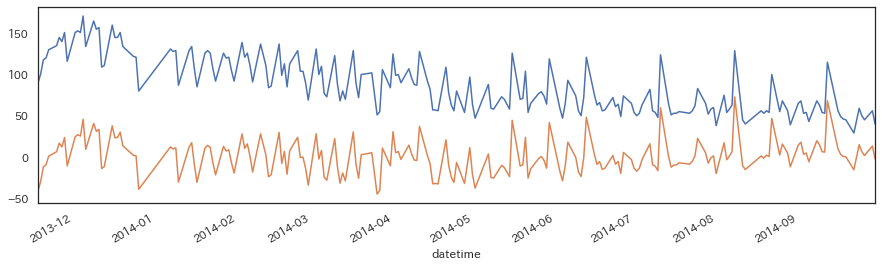

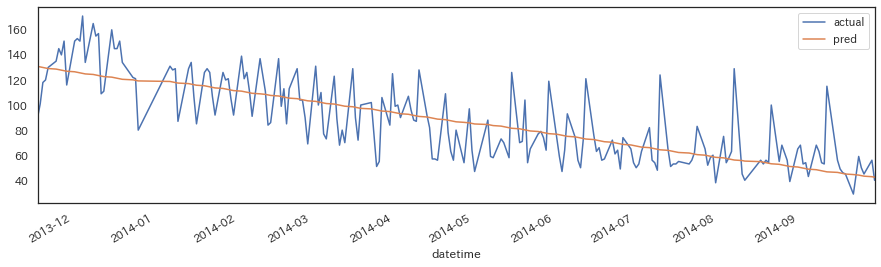

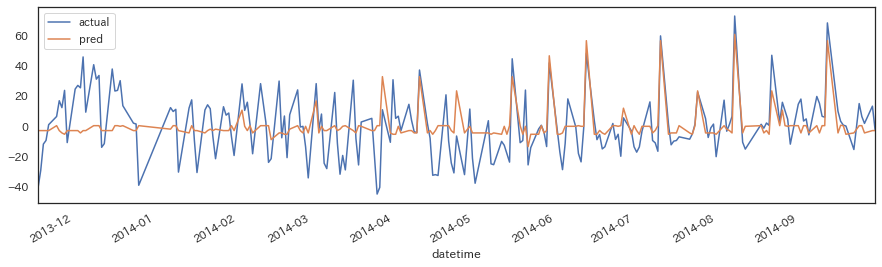

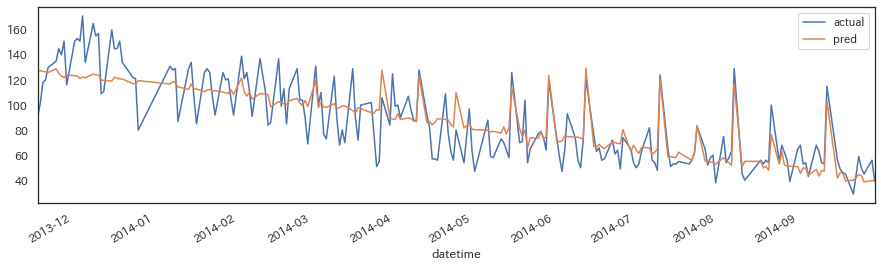

In [91]:
train["y"].plot(figsize=(15,4))
train_Y2.plot(figsize=(15,4))
v0 =  model1.predict(train_X1)
p0 = pd.DataFrame({"actual":train_Y,"pred":v0})
p0.plot(figsize=(15,4))
v1 =  model2.predict(train_X2)
p1 = pd.DataFrame({"actual":train_Y2,"pred":v1})
p1.plot(figsize=(15,4))

v2 =  model1.predict(train_X1) + model2.predict(train_X2)
p2 = pd.DataFrame({"actual":train_Y,"pred":v2})
p2.plot(figsize=(15,4))
plt.legend()

- ここからしばらく精度上げに苦戦。
- 違うアプローチができないかを模索。
- 過学習は今は考えないものとしている。

In [28]:
train["y2"] =train_Y2 

In [29]:
train.sort_values(by="y2")

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,...,temperature,month,fun,kodawari,curry,chiken,katu,days,pred,y2
datetime,,,,,,,,,,,,,,,,,,,,,
2014-03-26,2014-3-26,51,水,0,肉団子クリームシチュー,392.0,なし,なし,0.0,曇,...,18.7,3,0,0,0,0,0,81,96.065299,-45.065299
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,なし,なし,0.0,快晴,...,19.8,11,0,0,0,0,0,0,130.829431,-40.829431
2014-03-27,2014-3-27,55,木,1,ロース甘味噌焼き,315.0,なし,なし,0.0,曇,...,12.4,3,0,0,0,0,0,82,95.636112,-40.636112
2013-12-26,2013-12-26,80,木,0,酢豚,NaN,なし,なし,0.0,曇,...,7.3,12,0,0,0,0,0,27,119.241387,-39.241387
2014-05-02,2014-5-2,47,金,0,鶏の天ぷら,420.0,なし,なし,0.0,晴れ,...,23.3,5,0,0,0,0,0,107,84.906441,-37.906441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-22,2014-8-22,100,金,1,ロコモコ丼,NaN,お楽しみメニュー,なし,0.0,晴れ,...,33.1,8,1,0,0,0,0,181,53.146616,46.853384
2014-06-13,2014-6-13,121,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,...,29.5,6,1,0,1,0,0,135,72.889210,48.110790
2014-07-11,2014-7-11,124,金,0,ポークカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,...,33.9,7,1,0,1,0,0,155,64.305473,59.694527


# clusterの試み
- わかりやすい特徴量をまずは機械が作れるかを試行。
- ※失敗前提で実行
- これを踏まえた上で、何かに応用できないかを考える。

In [30]:
from sklearn.cluster import KMeans
KMeans_model=KMeans(n_clusters=3,random_state=10).fit(train_X2)

In [42]:
labels = KMeans_model.labels_
labels

array([2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2, 1,
       1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0, 0, 1,
       0, 0, 2, 2, 1, 2, 2, 0, 1, 2, 0, 1, 0, 2, 2, 1, 1, 2, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 1, 0,
       0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 2, 2])

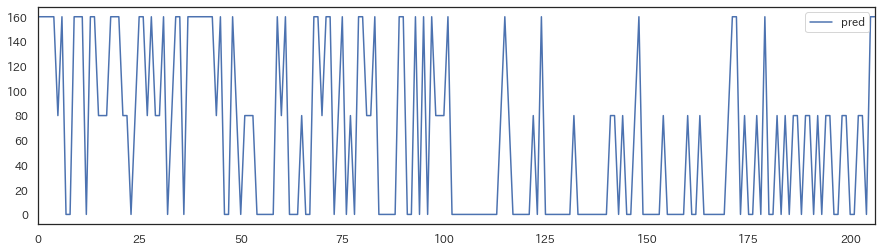

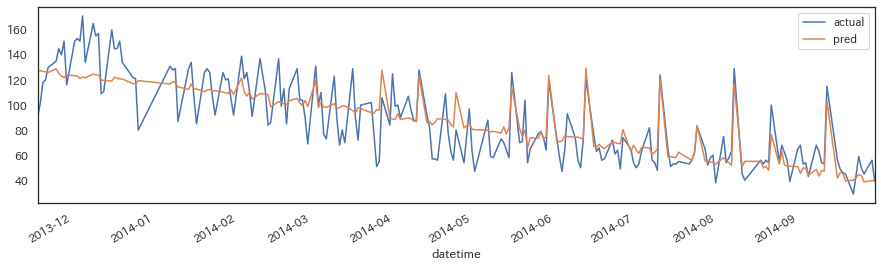

In [44]:
labels = labels *80
p3 = pd.DataFrame({"pred":labels})

p3.plot(figsize=(15, 4))
p2.plot(figsize=(15, 4))
plt.legend()

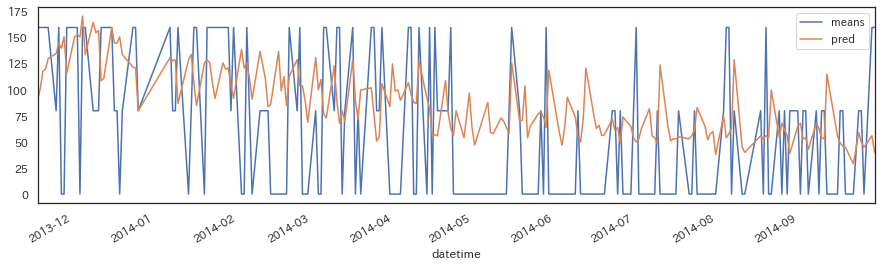

In [46]:
p4 = pd.DataFrame({"means":labels,"pred":train_Y})
p4.plot(figsize=(15, 4))

In [58]:
train["aid"] = labels

model11 = LR()
train_X11, train_Y1 = train["days"].values.reshape(-1,1), train["y"]
model11.fit(train_X11, train_Y1)

model22 = RF(n_estimators=500,max_depth=4,random_state=777)
train_X22= pd.get_dummies(train[["fun", "curry","weather", "aid","temperature"]])
train["pred"] = model11.predict(train_X11)
train_Y22 = train["y"] - train["pred"]
model22.fit(train_X22, train_Y22)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=777, verbose=0,
                      warm_start=False)

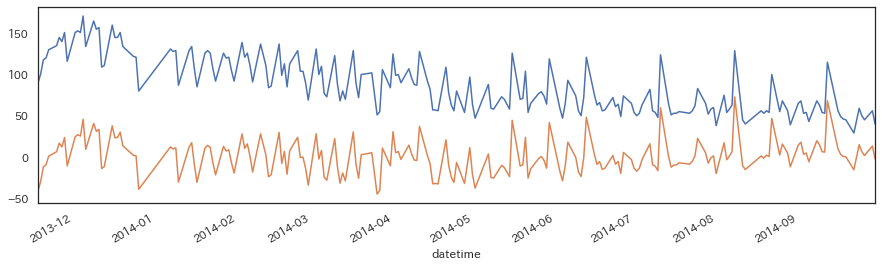

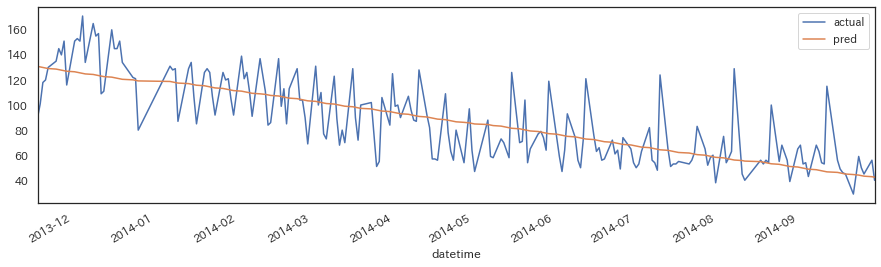

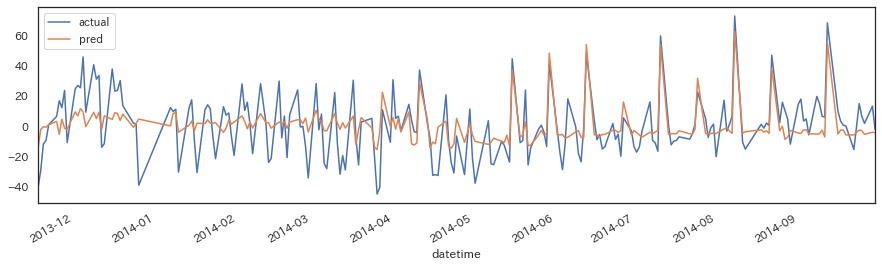

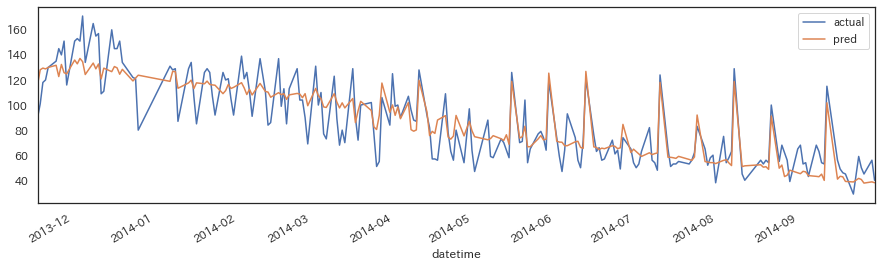

In [59]:
train["y"].plot(figsize=(15,4))
train_Y22.plot(figsize=(15,4))
v0 =  model11.predict(train_X11)
p0 = pd.DataFrame({"actual":train_Y1,"pred":v0})
p0.plot(figsize=(15,4))
v1 =  model22.predict(train_X22)
p1 = pd.DataFrame({"actual":train_Y22,"pred":v1})
p1.plot(figsize=(15,4))

v2 =  model11.predict(train_X11) + model22.predict(train_X22)
p22 = pd.DataFrame({"actual":train_Y1,"pred":v2})
p22.plot(figsize=(15,4))
plt.legend()

- 上記は案の定失敗した。
- 原因は同じデータを渡して、分類を任せても、結果的に同じ理論に基づいたものが吐かれている。
- 算出方法や基準を全く変えるような新しいものが欲しい。

# クラスターを用いて値を三つの分類に分けられるかを確かめる。
- yが高いもの、普通の値のモノ（一次関数上に近いもの）、低いものに分けたい。
- 今回は四分位範囲を用いて、25%未満⇒0,25%~75%⇒1,75%以上⇒2とする。

In [67]:
train.describe()

,y,soldout,kcal,payday,precipitation,temperature,month,fun,kodawari,curry,chiken,katu,days,pred,y2,aid
count,207.000000,207.000000,166.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,207.000000,2.070000e+02,207.000000
mean,86.623188,0.449275,404.409639,0.048309,-0.702899,19.252174,5.942029,0.057971,0.024155,0.082126,0.096618,0.154589,103.000000,86.623188,1.990893e-15,61.449275
std,32.882448,0.498626,29.884641,0.214939,0.878487,8.611365,3.274871,0.234255,0.153901,0.275222,0.296154,0.362389,59.899917,25.708255,2.050222e+01,66.623315
min,29.000000,0.000000,315.000000,0.000000,-1.000000,1.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.416945,-4.506530e+01,0.000000
25%,57.000000,0.000000,386.000000,0.000000,-1.000000,11.550000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.500000,64.520067,-1.318539e+01,0.000000
50%,78.000000,0.000000,408.500000,0.000000,-1.000000,19.800000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,86.623188,-2.198483e-01,80.000000
75%,113.000000,1.000000,426.000000,0.000000,-1.000000,26.100000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,154.500000,108.726310,1.135743e+01,160.000000
max,171.000000,1.000000,462.000000,1.000000,6.500000,34.600000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,206.000000,130.829431,7.284908e+01,160.000000


In [70]:
def cluster(x):
    if x >= 75:
        return 2
    elif x< 25:
        return 0
    else:
        return 1
train["class"] = train["y"].apply(lambda x :cluster(x))   

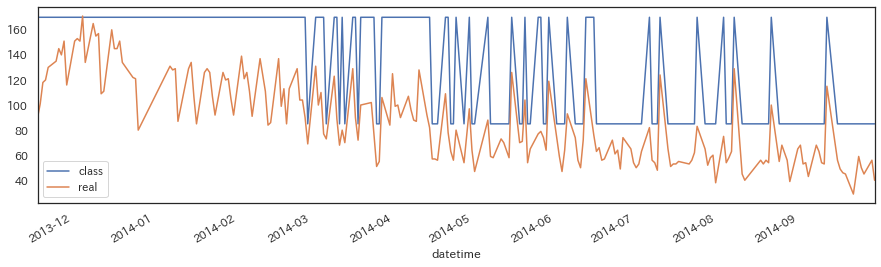

In [73]:
train["class1"] = train["class"] * 85
try_data = pd.DataFrame({"class":train["class1"],"real":train["y"]})
try_data.plot(figsize=(15,4))

- これでは使い物になってないため、線形予測を用いてやり直す。

In [79]:
train_Y22.describe()

count    2.070000e+02
mean     1.990893e-15
std      2.050222e+01
min     -4.506530e+01
25%     -1.318539e+01
50%     -2.198483e-01
75%      1.135743e+01
max      7.284908e+01
dtype: float64

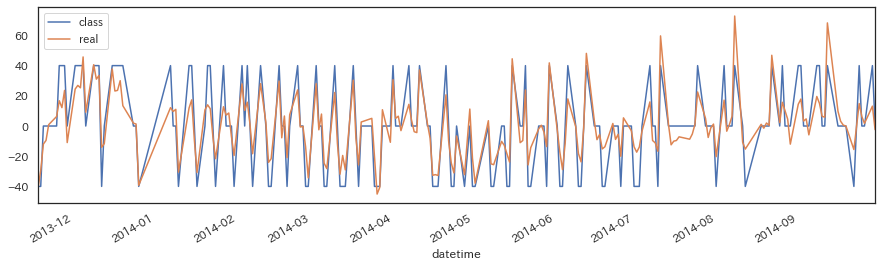

In [82]:
def cluster(x):
    if x >= 1.135743e+01:
        return 1
    elif x< -1.318539e+01:
        return -1
    else:
        return 0

train_Y22 = train["y"] - train["pred"]


train["class_1"] = train_Y22.apply(lambda x :cluster(x)) 
train["class1_1"] = train["class_1"] * 40
try_data = pd.DataFrame({"class":train["class1_1"],"real":train_Y22})
try_data.plot(figsize=(15,4))

In [87]:
model3 = LR()
train_X3, train_Y3 = train["days"].values.reshape(-1,1), train["y"]
model3.fit(train_X3, train_Y3)

model4 = RF(n_estimators=500,max_depth=4,random_state=777)
train_X4= pd.get_dummies(train[["fun", "curry","weather", "class_1","temperature"]])
train["pred"] = model3.predict(train_X3)
train_Y4 = train["y"] - train["pred"]
model4.fit(train_X4, train_Y4)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=777, verbose=0,
                      warm_start=False)

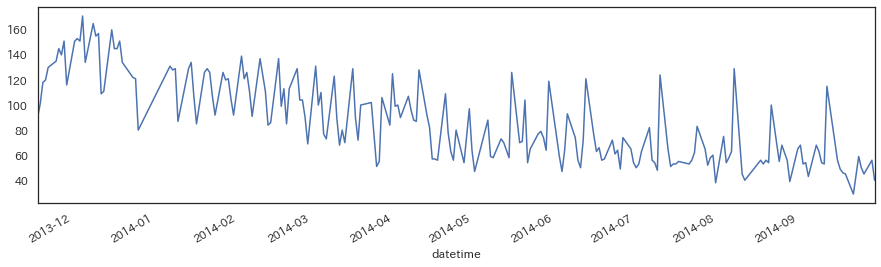

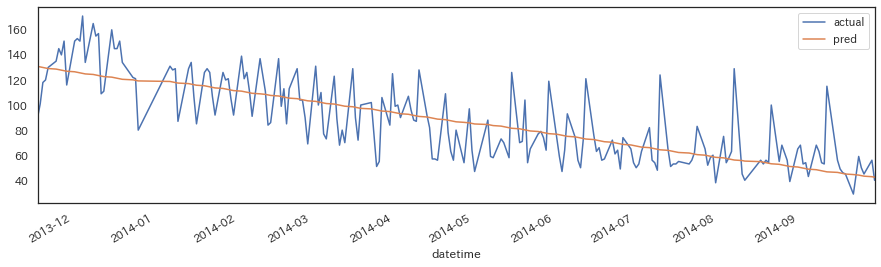

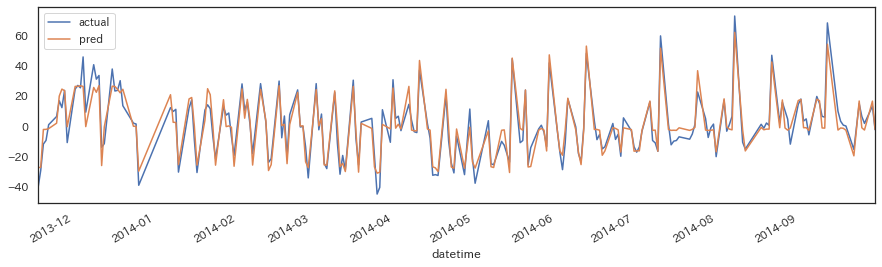

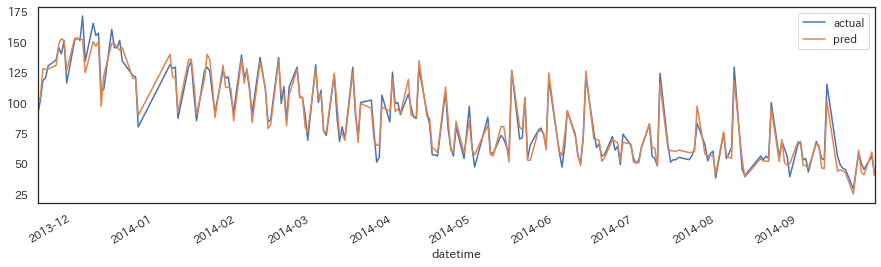

In [90]:

train_Y3.plot(figsize=(15,4))
v0 =  model11.predict(train_X3)
p0 = pd.DataFrame({"actual":train_Y3,"pred":v0})
p0.plot(figsize=(15,4))
v1 =  model4.predict(train_X4)
p1 = pd.DataFrame({"actual":train_Y4,"pred":v1})
p1.plot(figsize=(15,4))

v2 =  model3.predict(train_X3) + model4.predict(train_X4)
p22 = pd.DataFrame({"actual":train["y"],"pred":v2})
p22.plot(figsize=(15,4))
plt.legend()

## 新たな特徴量として使えるかの検討
- このクラスタを予測できれば、かなりの精度で予測が期待できる。（想定以上）
- これを予測する検討に入る。
### まとめ
- より判断が簡易なものを予測し精度を上げたものから、本来の予測値を算出させることを目指す。
- 段階的に予測できないかを今後検討していきたい。